##Załadowanie bibliotek 

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
import wget
import zipfile

In [18]:
wget.download('https://files.grouplens.org/datasets/movielens/ml-latest-small.zip')
with zipfile.ZipFile("ml-latest-small.zip","r") as zip_ref:
    zip_ref.extractall()

In [19]:
#load film data from csv

movies_data = pd.read_csv('ml-latest-small/movies.csv')

#show first 5 movies

print(movies_data.head())

   movieId                        title  \
0        1                    Toy Story   
1        2                      Jumanji   
2        3             Grumpier Old Men   
3        4            Waiting to Exhale   
4        5  Father of the Bride Part II   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1                   Adventure|Children|Fantasy  1995  
2                               Comedy|Romance  1995  
3                         Comedy|Drama|Romance  1995  
4                                       Comedy  1995  


In [20]:
#load user ratings from csv

ratings_data = pd.read_csv('ml-latest-small/ratings.csv')

#show first 5 ratings

print(ratings_data)

        userId  movieId  rating   timestamp
0            1        1     4.0   964982703
1            1        3     4.0   964981247
2            1        6     4.0   964982224
3            1       47     5.0   964983815
4            1       50     5.0   964982931
...        ...      ...     ...         ...
100831     610   166534     4.0  1493848402
100832     610   168248     5.0  1493850091
100833     610   168250     5.0  1494273047
100834     610   168252     5.0  1493846352
100835     610   170875     3.0  1493846415

[100836 rows x 4 columns]


In [21]:
merged_data = pd.merge(ratings_data, movies_data, on='movieId')
print(merged_data.head())

   userId  movieId  rating   timestamp      title  \
0       1        1     4.0   964982703  Toy Story   
1       5        1     4.0   847434962  Toy Story   
2       7        1     4.5  1106635946  Toy Story   
3      15        1     2.5  1510577970  Toy Story   
4      17        1     4.5  1305696483  Toy Story   

                                        genres  year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995  
1  Adventure|Animation|Children|Comedy|Fantasy  1995  
2  Adventure|Animation|Children|Comedy|Fantasy  1995  
3  Adventure|Animation|Children|Comedy|Fantasy  1995  
4  Adventure|Animation|Children|Comedy|Fantasy  1995  


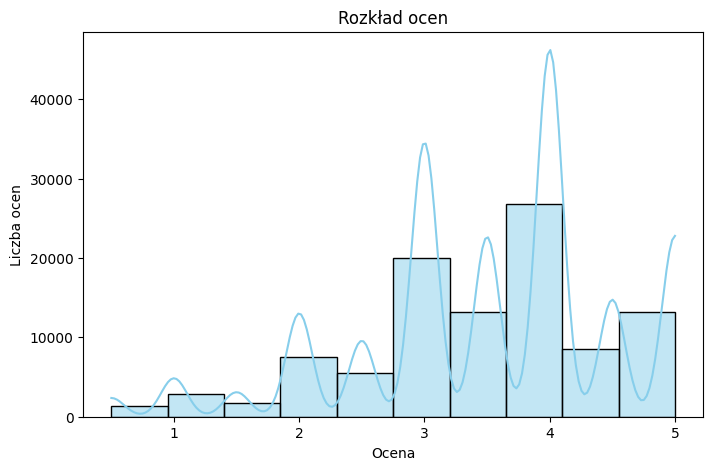

In [22]:
# Analiza rozkładu ocen
plt.figure(figsize=(8,5))
sns.histplot(merged_data['rating'], bins=10, kde=True, color='skyblue')
plt.title('Rozkład ocen')
plt.xlabel('Ocena')
plt.ylabel('Liczba ocen')
plt.show()

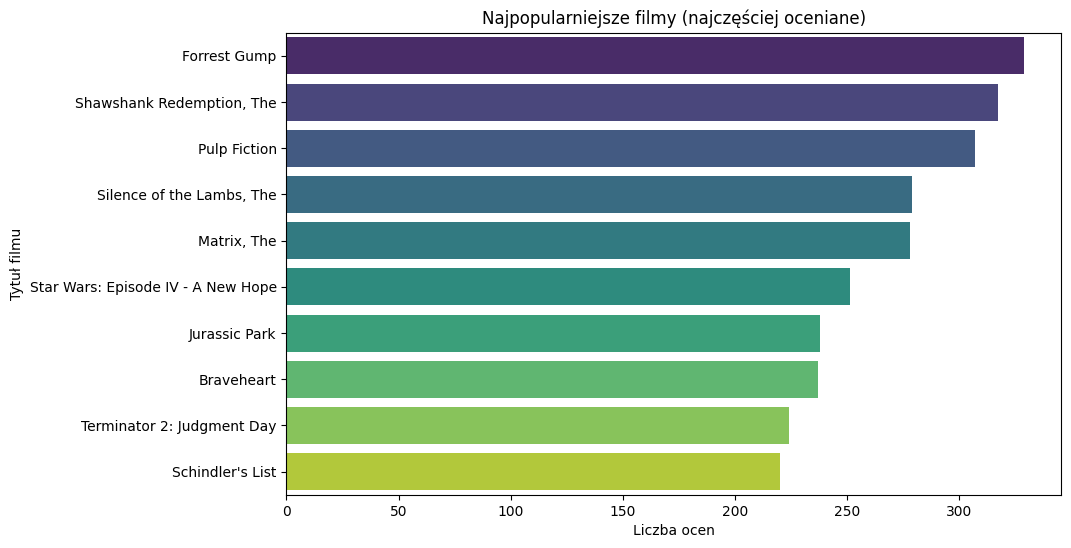

In [23]:
# Analiza popularności filmów (najczęściej ocenianych)
popular_movies = merged_data['title'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=popular_movies.index, x=popular_movies.values, palette='viridis')
plt.title('Najpopularniejsze filmy (najczęściej oceniane)')
plt.xlabel('Liczba ocen')
plt.ylabel('Tytuł filmu')
plt.show()

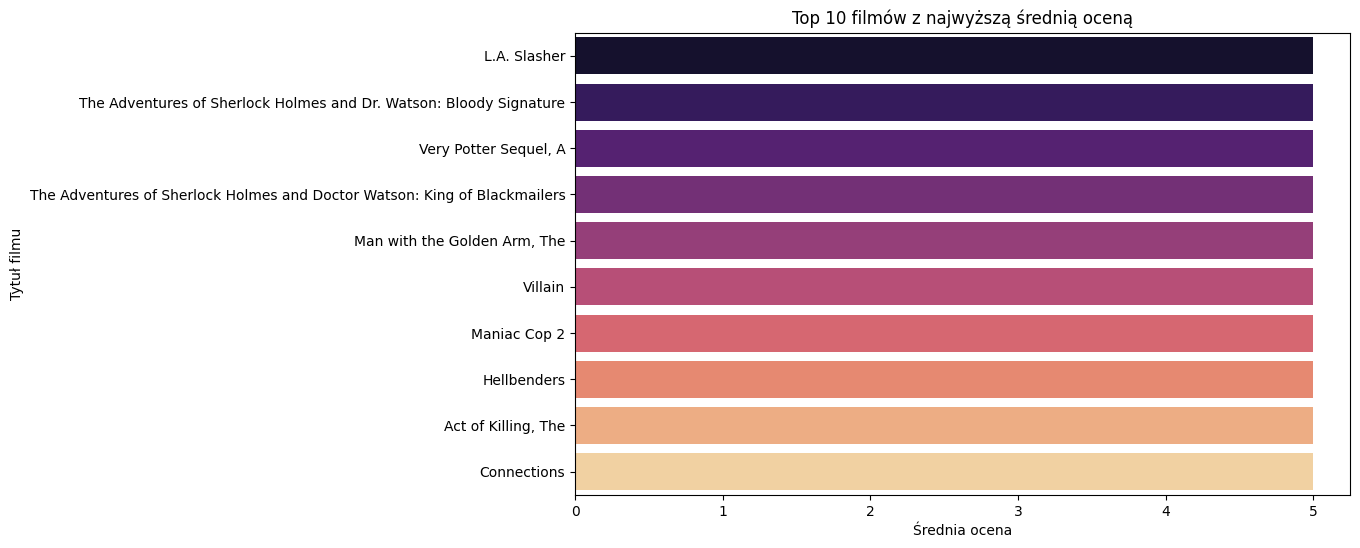

In [24]:

# Analiza średniej oceny dla poszczególnych filmów
average_ratings = merged_data.groupby('title')['rating'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
sns.barplot(y=average_ratings.index, x=average_ratings.values, palette='magma')
plt.title('Top 10 filmów z najwyższą średnią oceną')
plt.xlabel('Średnia ocena')
plt.ylabel('Tytuł filmu')
plt.show()

In [25]:
def movie_recommendation_system(user_id_to_find_recommendations_for, n_neighbors=10, top_recommendations=10):
    # Assuming you have already loaded the 'ratings.csv' and 'movies.csv'
    ratings_data = pd.read_csv('ml-latest-small/ratings.csv')
    movie_titles = pd.read_csv('ml-latest-small/movies.csv', index_col='movieId')['title']

    # Step 1: Prepare the data and create user-item matrix
    user_item_matrix = ratings_data.pivot(index='userId', columns='movieId', values='rating').fillna(0)

    # Step 2: Choose a collaborative filtering algorithm (k-Nearest Neighbors)
    knn_model = NearestNeighbors(n_neighbors=n_neighbors, metric='cosine', algorithm='brute')
    knn_model.fit(user_item_matrix.values)

    # Step 3: Make movie recommendations for the specified user
    user_index = user_item_matrix.index.get_loc(user_id_to_find_recommendations_for)
    user_ratings = user_item_matrix.iloc[user_index].values

    # Step 4: Find the nearest neighbors (similar users) to the target user
    user_ratings_reshaped = user_ratings.reshape(1, -1)  # Reshape to a 2D array with one row
    _, indices = knn_model.kneighbors(user_ratings_reshaped)

    # Step 5: Get movie recommendations based on similar users' preferences
    similar_users_indices = indices.squeeze()
    recommendations = user_item_matrix.iloc[similar_users_indices].mean(axis=0)
    sorted_recommendations = recommendations.sort_values(ascending=False)

    # Print the top movie recommendations
    recommended_movies = sorted_recommendations.head(top_recommendations)
    print(f"Top {top_recommendations} movie recommendations for user {user_id_to_find_recommendations_for}:")
    for movie_id, rating in recommended_movies.items():
        print(f"Movie: '{movie_titles[movie_id]}', Predicted Rating: {rating:.2f}")

# Example usage:
user_id = 200
movie_recommendation_system(user_id)


Top 10 movie recommendations for user 200:
Movie: 'Matrix, The (1999)', Predicted Rating: 4.55
Movie: 'Fight Club (1999)', Predicted Rating: 4.25
Movie: 'Good Will Hunting (1997)', Predicted Rating: 4.10
Movie: 'Lord of the Rings: The Return of the King, The (2003)', Predicted Rating: 4.05
Movie: 'Shrek (2001)', Predicted Rating: 4.00
Movie: 'Harry Potter and the Prisoner of Azkaban (2004)', Predicted Rating: 3.95
Movie: 'Finding Nemo (2003)', Predicted Rating: 3.95
Movie: 'Aladdin (1992)', Predicted Rating: 3.90
Movie: 'Lord of the Rings: The Two Towers, The (2002)', Predicted Rating: 3.90
Movie: 'Eternal Sunshine of the Spotless Mind (2004)', Predicted Rating: 3.90


In [45]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

def content_based_recommendation_system(movie_title_to_find_recommendations_for, top_recommendations=10):
    # Załóżmy, że dane 'movies.csv' zostały już załadowane
    movies_data = pd.read_csv('ml-latest-small/movies.csv')

    # Rozbij kolumnę "title" na osobne kolumny "title" i "year"
    movies_data[['title', 'year']] = movies_data['title'].str.extract(r'^(.*?)\s\((\d{4})\)$')

    # Wypełnij brakujące wartości w kolumnie "title" pustymi łańcuchami
    movies_data['title'] = movies_data['title'].fillna('')

    # Sprawdź, czy podany tytuł filmu istnieje w zbiorze danych
    if movie_title_to_find_recommendations_for not in movies_data['title'].values:
        print(f"Film o tytule '{movie_title_to_find_recommendations_for}' nie istnieje w zbiorze danych.")
        return

    # Krok 1: Przygotuj dane i stwórz macierz TF-IDF dla tytułów filmów
    tfidf_vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(movies_data['title'])

    # Krok 2: Oblicz podobieństwo kosinusowe pomiędzy tytułami filmów
    cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

    # Krok 3: Znajdź indeks filmu, dla którego chcemy dokonać rekomendacji
    movie_index = movies_data.index[movies_data['title'] == movie_title_to_find_recommendations_for].tolist()[0]

    # Krok 4: Uzyskaj oceny podobieństwa (podobne tytuły filmów) dla danego filmu
    similar_movies_indices = cosine_similarities[movie_index].argsort()[::-1][1:]

    # Krok 5: Wyświetl rekomendacje filmów na podstawie treści (tytułów)
    recommended_movies = movies_data.iloc[similar_movies_indices][:top_recommendations]
    print(f"Top {top_recommendations} rekomendacji filmów dla filmu o tytule '{movie_title_to_find_recommendations_for}':")
    for idx, movie in recommended_movies.iterrows():
        print(f"Film: '{movie['title']}', Rok produkcji: {movie['year']}, Gatunek: {movie['genres']}")

# Przykładowe użycie:
movie_title = "Pulp Fiction"
content_based_recommendation_system(movie_title)


Top 10 rekomendacji filmów dla filmu o tytule 'Pulp Fiction':
Film: 'Stranger than Fiction', Rok produkcji: 2006, Gatunek: Comedy|Drama|Fantasy|Romance
Film: 'Andrew Dice Clay: Dice Rules', Rok produkcji: 1991, Gatunek: Comedy
Film: 'Cats & Dogs', Rok produkcji: 2001, Gatunek: Children|Comedy
Film: 'Another Woman', Rok produkcji: 1988, Gatunek: Drama
Film: 'Alice', Rok produkcji: 1990, Gatunek: Comedy|Drama|Fantasy|Romance
Film: 'Rape Me (Baise-moi)', Rok produkcji: 2000, Gatunek: Crime|Drama|Thriller
Film: 'Lost and Delirious', Rok produkcji: 2001, Gatunek: Drama
Film: 'Scary Movie 2', Rok produkcji: 2001, Gatunek: Comedy
Film: 'Kiss of the Dragon', Rok produkcji: 2001, Gatunek: Action
Film: 'Lumumba', Rok produkcji: 2000, Gatunek: Drama
